### 필요한 라이브러리 불러오기

#### 데이터 개수


- 10년(2012 ~ 2021) * 6개월=184일(5/1~10/31) * 1일(24 * 6) = 264960개

- 1년(2022) * 2개월=79일(5/1~7/18) * 1일(24 * 6) = 11376개

#### Water Data(data_2012.csv)

- ymdhm : 년월일시분
- swl : 팔당댐 현재수위 (단위: El.m)
- inf : 팔당댐 유입량 (단위: m^3/s)
- sfw : 팔당댐 저수량 (단위: 만m^3)
- ecpc : 팔당댐 공용량 (단위: 백만m^3)
- tototf : 총 방류량 (단위: m^3/s)
- tide_level : 강화대교 조위 (단위: cm)
-     
- wl_1018662 : 청담대교 수위 (단위: cm)
- wl_1018680 : 잠수교 수위 (단위: cm)
- wl_1018683 : 한강대교 수위 (단위: cm)
- wl_1019630 : 행주대교 수위 (단위: cm)
- 
- fw_1018662 : 청담대교 유량 (단위: m^3/s)
- fw_1018680 : 잠수교 유량 (단위: m^3/s)
- fw_1018683 : 한강대교 유량 (단위: m^3/s)    
- fw_1019630 : 행주대교 유량 (단위: m^3/s)

    
#### RainFall Data(rf_2012.csv)

- YMDHM : 년월일시분
- rf_10184100 : 대곡교 강수량
- rf_10184110 : 진관교 강수량
- rf_10184140 : 송정동 강수량

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### pytoch

In [ ]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user
# 설치 후 런타임 다시시작

In [ ]:
import sklearn

!pip install pycaret

from pycaret.utils import enable_colab
enable_colab()

!pip install markupsafe==2.0.1
# 설치 후 런타임 다시시작

In [ ]:
import jinja2
from pycaret.regression import *

!pip install catboost

In [ ]:
!pip install optuna

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

### import

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

import os
from glob import glob
from tqdm import tqdm
from scipy import interpolate
import pickle
import datetime as dt
import joblib
import time

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from itertools import permutations, combinations

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_tree, plot_importance
from lightgbm import LGBMRegressor
#from catboost import CatBoostClassifier, Pool, CatBoostRegressor

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostRegressor,  HistGradientBoostingRegressor, StackingRegressor, RandomForestRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')

## water_rf_data(water_data + rf_data) 제작
#w_list = sorted(glob("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_data/*.csv"))
#r_list = sorted(glob("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/rf_data/*.csv"))
#for i in list(range(2012, 2023)):
#  globals()['w{0}'.format(i)] = pd.read_csv(w_list[i-2012])
#  globals()['r{0}'.format(i)] = pd.read_csv(r_list[i-2012])
#  globals()['wr{0}'.format(i)] = pd.concat([globals()['w{0}'.format(i)], globals()['r{0}'.format(i)]],axis=1) # 두 데이터프레임 결합
#for i in list(range(2012, 2023)):
#  globals()['wr{0}'.format(i)].to_csv('wr{0}.csv'.format(i), index = False)

wr_list = sorted(glob("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/*.csv")) # 2012~2021 + 2022-05-01 00:00 ~ 2022-07-18 23:50 
sample_submission = pd.read_csv("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/sample_submission.csv", index_col=0) # 2022-06-01 00:00	~ 2022-07-18 23:50	6912개
wr_list

['./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2012.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2013.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2014.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2015.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2016.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2017.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2018.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2019.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2020.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2021.csv',
 './drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/wr2022.csv']

In [6]:
# 전체 데이터프레임 결합(2012~2021년)
df_list = []
for i in wr_list:
    df_list.append(pd.read_csv(i))

df = pd.concat(df_list, ignore_index=True)
df = df.drop(['ymdhm.1'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ymdhm        276336 non-null  object 
 1   swl          275593 non-null  float64
 2   inf          275593 non-null  float64
 3   sfw          275593 non-null  float64
 4   ecpc         275593 non-null  float64
 5   tototf       275593 non-null  float64
 6   tide_level   271409 non-null  float64
 7   wl_1018662   276277 non-null  float64
 8   fw_1018662   259956 non-null  float64
 9   wl_1018680   276277 non-null  float64
 10  fw_1018680   79487 non-null   float64
 11  wl_1018683   276277 non-null  float64
 12  fw_1018683   275057 non-null  float64
 13  wl_1019630   276277 non-null  float64
 14  fw_1019630   276277 non-null  float64
 15  rf_10184100  276336 non-null  float64
 16  rf_10184110  276336 non-null  float64
 17  rf_10184140  276336 non-null  float64
dtypes: float64(17), object(1

### 데이터 전처리

In [7]:
def date_conv(df):
    df['ymdhm'] = pd.to_datetime(df['ymdhm'])
    df['year'] = df['ymdhm'].dt.year
    df['month'] =df['ymdhm'].dt.month
    df['day'] =df['ymdhm'].dt.day
    df['hour'] =df['ymdhm'].dt.hour
    df['minute'] =df['ymdhm'].dt.minute
    df['weekday'] = df['ymdhm'].dt.weekday
    df = df.drop('ymdhm', axis=1)
    return df

df = date_conv(df)
#df = df.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'weekday'])
df.shape

(276336, 23)

### 데이터 결측치

In [8]:
df = df.fillna(df.mean())
df

,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140,year,month,day,hour,minute,weekday
0,24.800,555.00,219.07,24.93,555.00,445.0,310.7,469.05,300.2,0.0,290.0,729.80,275.3,540.18,0.0,0.0,0.0,2012,5,1,0,0,1
1,24.794,464.60,218.86,25.15,562.90,449.0,314.7,498.00,300.2,0.0,290.0,731.48,275.3,540.18,0.0,0.0,0.0,2012,5,1,0,10,1
2,24.789,478.10,218.69,25.31,576.40,451.0,313.7,490.68,301.2,0.0,290.0,726.42,275.3,540.18,0.0,0.0,0.0,2012,5,1,0,20,1
3,24.789,464.80,218.69,25.31,563.10,452.0,311.7,476.21,301.2,0.0,290.0,726.42,276.3,552.17,0.0,0.0,0.0,2012,5,1,0,30,1
4,24.789,478.10,218.69,25.31,576.40,450.0,311.7,476.21,301.2,0.0,291.0,707.17,277.3,564.29,0.0,0.0,0.0,2012,5,1,0,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,25.040,259.23,212.86,31.14,259.23,510.0,0.0,319.84,0.0,0.0,0.0,-456.41,0.0,974.40,0.0,0.0,0.0,2022,7,18,23,10,0
276332,25.040,260.46,212.86,31.14,260.46,492.0,0.0,314.01,0.0,0.0,0.0,-717.30,0.0,1006.88,0.0,0.0,0.0,2022,7,18,23,20,0
276333,25.040,259.37,212.86,31.14,259.37,475.0,0.0,387.55,0.0,0.0,0.0,-843.37,0.0,1039.90,0.0,0.0,0.0,2022,7,18,23,30,0
276334,25.040,259.13,212.86,31.14,259.13,458.0,0.0,454.91,0.0,0.0,0.0,-1023.37,0.0,1073.46,0.0,0.0,0.0,2022,7,18,23,40,0


### train, val, test 데이터셋 만들기

In [9]:
Y = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
X = df.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)

X_train = X.iloc[:251712, :]
y_train = Y.iloc[:251712, :]

X_val = X.iloc[251712:269424, :]
y_val = Y.iloc[251712:269424, :]

X_test = X.iloc[269424:, :]
y_test = Y.iloc[269424:, :] # =submission

train_data = X.iloc[:269424, :]
train_target = Y.iloc[:269424, :]
test_data = X.iloc[269424:, :]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(251712, 19) (251712, 4) (17712, 19) (17712, 4) (6912, 19) (6912, 4)


### 제작 model

In [ ]:
ada = create_model('ada')


In [ ]:
# 1시간 10분
from catboost import CatBoostClassifier, CatBoostRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning) #경고메세지 끄기
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

# 데이터
df_train = df.iloc[:269424, :]

# 모델링
model = setup(df_train, target = 'wl_1018662', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True, ignore_low_variance = True,
              pca = False, normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
top5 = compare_models(exclude = ['svm', 'knn', 'huber', 'lasso', 'ada', 'dt', 'lr'],round=4,n_select=5,sort='RMSE') # 전체 : rf, et,catboost, lightgbm, gbr 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0487,0.0819,0.2858,0.9999,0.0011,0.0002,20.835
et,Extra Trees Regressor,0.0493,0.0849,0.2908,0.9999,0.0011,0.0002,7.916
catboost,CatBoost Regressor,0.1593,0.1541,0.3925,0.9999,0.0014,0.0005,16.843
lightgbm,Light Gradient Boosting Machine,0.1257,0.1831,0.4259,0.9999,0.0015,0.0004,0.641
gbr,Gradient Boosting Regressor,0.8226,1.6424,1.2811,0.9989,0.0043,0.0027,12.383
ridge,Ridge Regression,4.4284,34.5418,5.8771,0.9773,0.0187,0.0142,0.315
lar,Least Angle Regression,4.4284,34.5418,5.8771,0.9773,0.0187,0.0142,0.037
br,Bayesian Ridge,4.4284,34.5418,5.8771,0.9773,0.0187,0.0142,0.047
par,Passive Aggressive Regressor,5.3615,50.3656,7.0738,0.9669,0.0224,0.0171,0.147
omp,Orthogonal Matching Pursuit,5.5954,61.6607,7.8522,0.9594,0.0242,0.0177,0.040


In [7]:
models = []
X_train1 = X.iloc[:269424, :]
y_train1 = Y.iloc[:269424, :]
top5 = finalize_model(top5)
final_model = top5.fit(X_train1, y_train1)
models.append(final_model)

NameError: ignored

In [ ]:
# 모델 저장(2.37GB)
import joblib

joblib.dump(top5, open('top5.model', 'wb'))

In [ ]:
# 모델 불러오기
top = joblib.load(open('./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/top5.model', 'rb'))  

In [ ]:
# 1시간 20분
tuned_top5 = [tune_model(i) for i in top5] # 모델 안의 파라미터 값 튜닝
blender_top5 = blend_models(estimator_list=tuned_top5) # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:37:01
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Fold,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
dt = create_model('dt')
rf = create_mocdl('rf')
ada = create_model('ada')

blender_specific = blend_models(estimator_list = [dt, rf, ada], method = 'soft')


In [ ]:
# 모델 저장
import joblib

joblib.dump(final_model, open('final_model.model', 'wb'))

In [ ]:
models = []
X_train1 = X.iloc[:269424, :]
y_train1 = Y.iloc[:269424, :]

# 모델 학습
final_model = top.fit(X_train1, y_train1)
models.append(final_model

AttributeError: ignored

In [ ]:
# 모델 저장
import joblib

joblib.dump(models, open('model{0}.model'.format(i), 'wb'))

### 전체 pycaret

In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning) #경고메세지 끄기
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

# 데이터
df_train = df.iloc[:269424, :]
X_train1 = X.iloc[:269424, :]
y_train1 = Y.iloc[:269424, :]

# 모델링
models = []
for j in ["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]:
  model = setup(df_train, target = j, fold_shuffle=True, fold=10, 
                session_id=530, remove_multicollinearity = True, ignore_low_variance = True,
                pca = False, normalize= True, n_jobs = -1, silent = True, remove_outliers= True
                )
  top5 = compare_models(exclude = ['svm'],round=4,n_select=5,sort='RMSE')
  tuned_top5 = [tune_model(i) for i in top5] # 모델 안의 파라미터 값 튜닝
  blender_top5 = blend_models(estimator_list=tuned_top5) # 5개의 모델을 혼합한 모델
  final_model = finalize_model(blender_top5)
  final_model = final_model.fit(X_train1, y_train1)
  models.append(final_model)

In [ ]:
X_test1 = X.iloc[269424:, :]

preds = []
for i in range(4):
  pred = models[i].predict(X_test1)
preds.append(pred)

### model(publlic:3.2523364354)

In [20]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

# 데이터
Y = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
X = df.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)
#X = df[["hour", "minute", "weekday"]]
train_data = X.iloc[:269424, :]
train_target = Y.iloc[:269424, :]
test_data = X.iloc[269424:, :]

# 모델
kfold = KFold(n_splits=2, shuffle=True)
#params = {"n_estimators" : (100, 150, 200)}
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)

# 학습, 예측
rf.fit(train_data, train_target)
y_pred = rf.predict(test_data)

sample_submission.iloc[:,:] = y_pred
sample_submission.to_csv('ans.csv')
sample_submission

KeyboardInterrupt: ignored

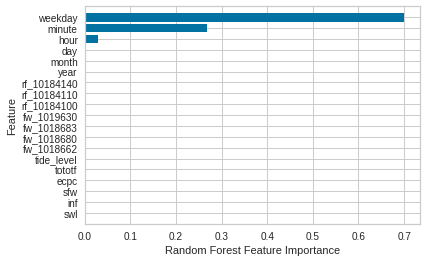

In [17]:
def plot_feature_importance(model):
    n_features = train_data.shape[1]
    plt.barh(np.arange(n_features), sorted(model.feature_importances_), align="center")
    plt.yticks(np.arange(n_features), train_data.columns)
    plt.xlabel("Random Forest Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importance(rf)

### 모델링 및 모델 학습

In [ ]:
import gc
gc.collect()

88

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from tensorflow.keras import layers
#from tensorflow.keras import layers as L

input_shape = (train_data[0].shape[0], train_data[0].shape[1])

# https://buomsoo-kim.github.io/keras/2019/08/02/Easy-deep-learning-with-Keras-22.md/ : CuDNN을 활용한 GRU


model = Sequential()
model.add(GRU(256, return_sequences = True, input_shape=input_shape))
model.add(GRU(128, return_sequences = False)) 
model.add(Dense(4, activation = 'relu'))

#inputs = L.Input(shape = (data_for_scaler.shape[1], data_for_scaler.shape[2]))
#gru1 = L.GRU(256, return_sequences = True, dropout = 0.2)(inputs)
#ap = L.AveragePooling1D()(gru1)
#gru2 = L.GRU(150, return_sequences = True)(ap)
#GAP = L.GlobalAveragePooling1D()(gru2)
#dense = L.Dense(61, activation = "softmax")(GAP)

#optimizer = tf.optimizers.RMSprop(0.001)
optimizer = tf.optimizers.Adam(0.001)
#optimizer = tf.optimizers.AdamW(0.001)


model.compile(optimizer=optimizer,loss='mse', metrics=['mae'])

In [ ]:
def cudnn_gru_model():
    model = Sequential()
    model.add(CuDNNGRU(50, input_shape = (300,1), return_sequences = True))
    model.add(CuDNNGRU(1, return_sequences = False))
    model.add(Activation('sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [ ]:
model.fit(train_data, train_label, epochs=10, batch_size=128)

Epoch 1/10
2037/2037 [==============================] - 154s 72ms/step - loss: 46245.2617 - mae: 195.2990
Epoch 2/10
2037/2037 [==============================] - 150s 74ms/step - loss: 6935.7695 - mae: 52.7049
Epoch 3/10
2037/2037 [==============================] - 150s 74ms/step - loss: 3313.0037 - mae: 26.5996
Epoch 4/10
2037/2037 [==============================] - 150s 74ms/step - loss: 1470.4374 - mae: 11.2595
Epoch 5/10
2037/2037 [==============================] - 150s 73ms/step - loss: 774.6173 - mae: 8.8993
Epoch 6/10
2037/2037 [==============================] - 150s 73ms/step - loss: 510.9503 - mae: 8.7359
Epoch 7/10
2037/2037 [==============================] - 149s 73ms/step - loss: 411.4238 - mae: 8.8388
Epoch 8/10
2037/2037 [==============================] - 149s 73ms/step - loss: 368.9583 - mae: 8.5363
Epoch 9/10
2037/2037 [==============================] - 149s 73ms/step - loss: 303.2803 - mae: 8.5472
Epoch 10/10
2037/2037 [==============================] - 148s 72ms/step 

### 추론 데이터셋 만들기

In [ ]:
test_data = []
test_label = []

tmp = pd.read_csv(w_list[-1])
tmp = tmp.replace(" ", np.nan)
# 이전값을 사용
tmp = tmp.fillna(method = 'pad')
tmp = tmp.fillna(0)
    
#tmp.loc[:, ["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]] = tmp.loc[:, ["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]*100
    
for j in tqdm(range(4032, len(tmp)-432)):
    test_data.append(np.array(tmp.loc[j:j + 431, ["swl", "inf", "sfw", "ecpc",
                                                    "tototf", "tide_level",
                                                    "fw_1018662", "fw_1018680",
                                                    "fw_1018683", "fw_1019630"]]).astype(float))
        
    test_label.append(np.array(tmp.loc[j + 432, ["wl_1018662", "wl_1018680",
                                                    "wl_1018683", "wl_1019630"]]).astype(float))

100%|██████████| 6912/6912 [00:07<00:00, 978.91it/s]


In [ ]:
test_data = np.array(test_data)
test_label = np.array(test_label)

print(test_data.shape)
print(test_label.shape)

(6912, 432, 10)
(6912, 4)


### 제출 파일 만들기

In [ ]:
pred = model.predict(test_data)

In [ ]:
pred = pd.DataFrame(pred)

In [ ]:
sample_submission = pd.read_csv("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/sample_submission.csv")

sample_submission["wl_1018662"] = pred[0]
sample_submission["wl_1018680"] = pred[1]
sample_submission["wl_1018683"] = pred[2]
sample_submission["wl_1019630"] = pred[3]

In [ ]:
sample_submission.to_csv("baseline.csv", index = False)

### RandomForest Tune

In [24]:
len(train_data.columns)

19

In [ ]:
from optuna import Trial, visualization
import numpy as np

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 1, X.shape[1], step=1), # 변수의 개수
        #'max_depth' : trial.suggest_int("max_depth", 2, 8) # 기본값=None(무제한)
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, train_data.values, train_target.values), n_trials=10)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

best_param2 = study.best_trial.params
rf = RandomForestRegressor(**best_param2, objective='regression', metric='root_mean_squared_error', learning_rate= 0.01, boosting_type='gbdt')
rf.fit(train_data, train_target)
pred3 = rf.predict(test_data)
pred3

[I 2022-08-04 11:04:50,507] A new study created in memory with name: no-name-f78e0fb2-745f-4582-b3f6-938331000195
[I 2022-08-04 11:11:21,124] Trial 0 finished with value: 1.9697453901350126 and parameters: {'n_estimators': 460, 'max_features': 4}. Best is trial 0 with value: 1.9697453901350126.
[I 2022-08-04 11:23:01,384] Trial 1 finished with value: 1.5980803877962466 and parameters: {'n_estimators': 590, 'max_features': 7}. Best is trial 1 with value: 1.5980803877962466.


In [48]:
train_data.values.shape

(269424, 19)

In [49]:
train_target.shape

(269424, 4)